In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import kagglehub
import warnings
warnings.filterwarnings('ignore')

In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path
file_path = "IMDB Dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
  file_path,
)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Basic Data Exploration
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

Dataset Shape: (50000, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Missing Values:
review       0
sentiment    0
dtype: int64

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [6]:
# Convert sentiment to binary labels
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment,sentiment_label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


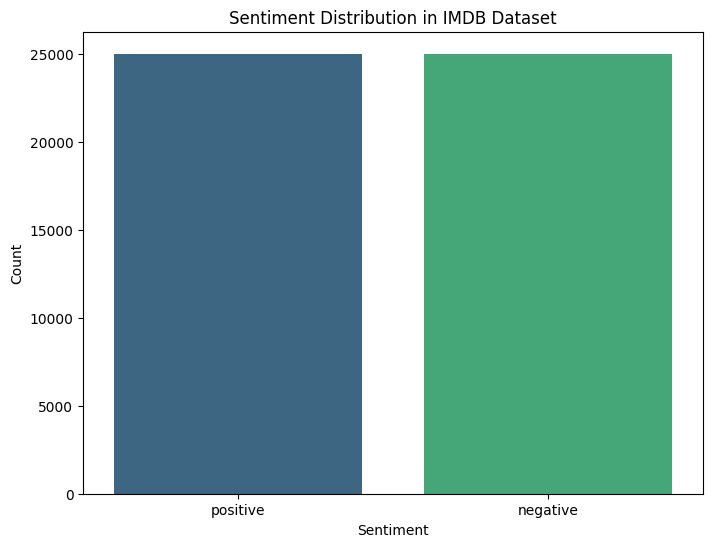

In [7]:
# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution in IMDB Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('sentiment_distribution.png')
plt.show()

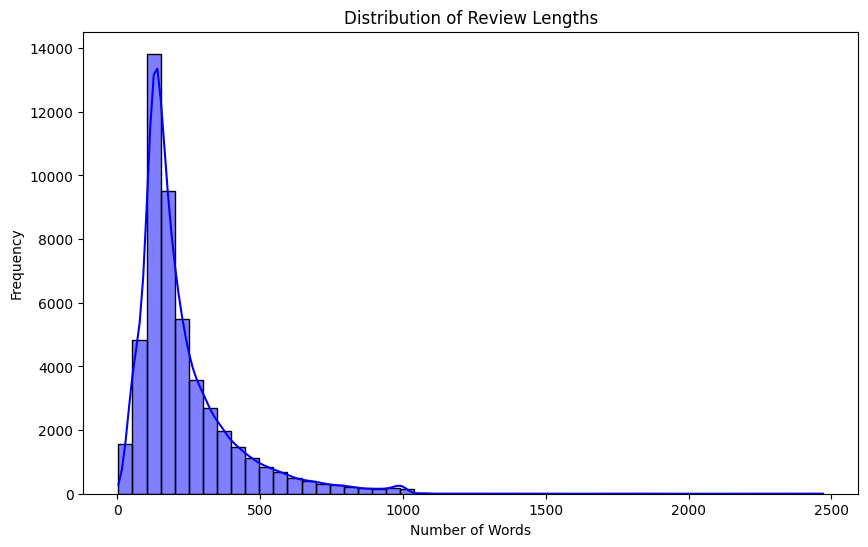

In [8]:
#  Review Length Distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.savefig('review_length_distribution.png')
plt.show()

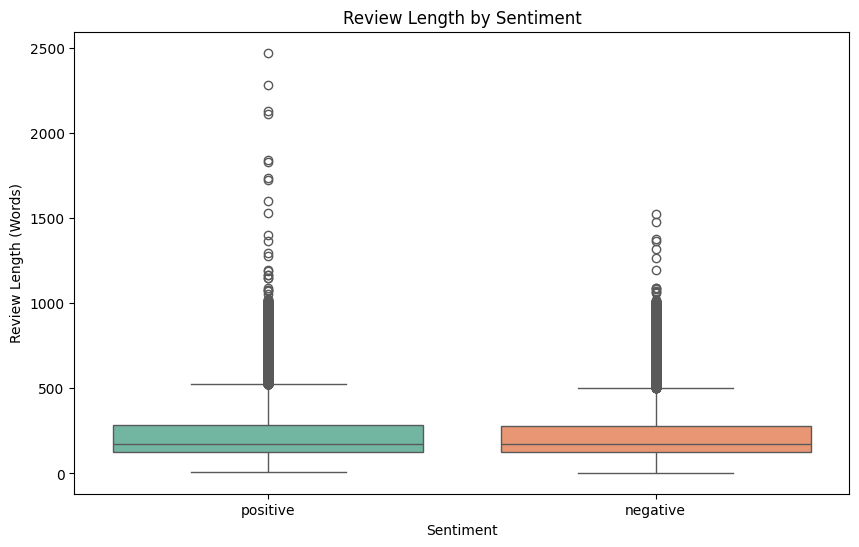

In [9]:
# Review Length by Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Words)')
plt.savefig('review_length_by_sentiment.png')
plt.show()

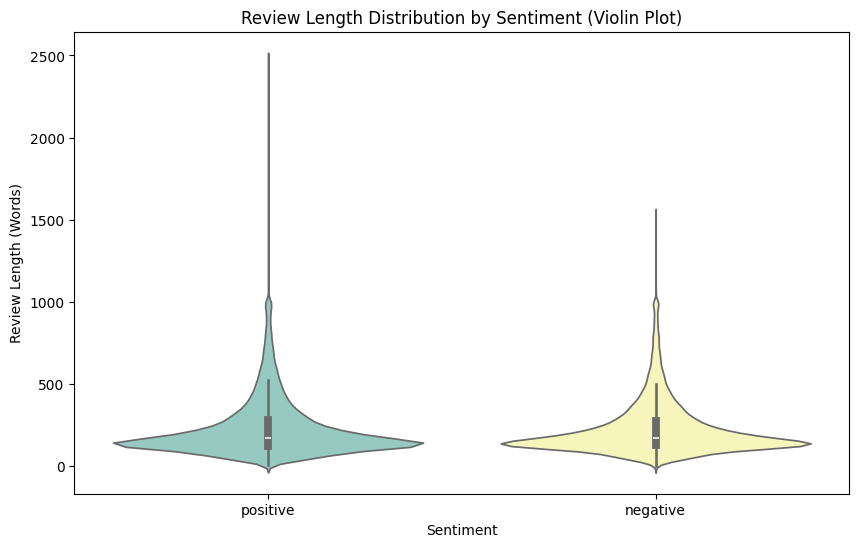

In [10]:
# Review Length by Sentiment (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x='sentiment', y='review_length', data=df, palette='Set3')
plt.title('Review Length Distribution by Sentiment (Violin Plot)')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Words)')
plt.savefig('review_length_violin.png')
plt.show()

In [13]:
#  Text Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)
df.head()

,review,sentiment,sentiment_label,review_length,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1,307,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,1,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,138,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,petter matteis love time money visually stunni...


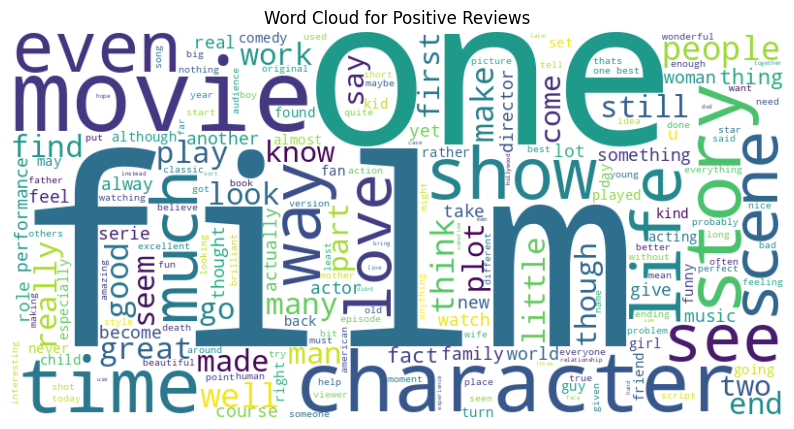

In [14]:
# Word Cloud for Positive Reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(positive_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.savefig('positive_wordcloud.png')
plt.show()

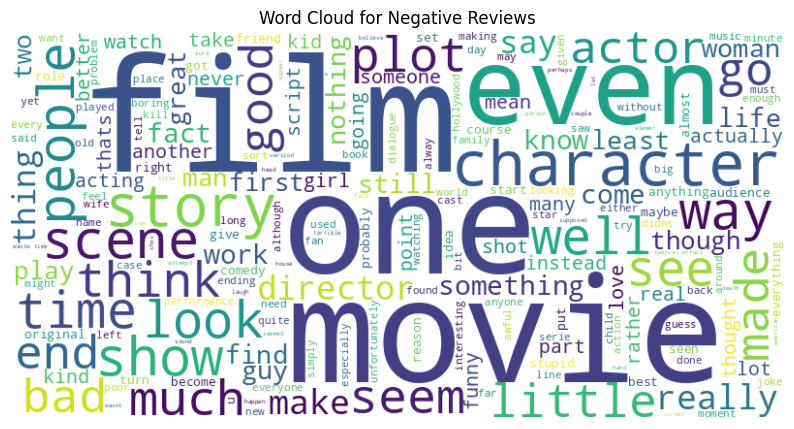

In [15]:
#  Word Cloud for Negative Reviews
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(negative_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.savefig('negative_wordcloud.png')
plt.show()

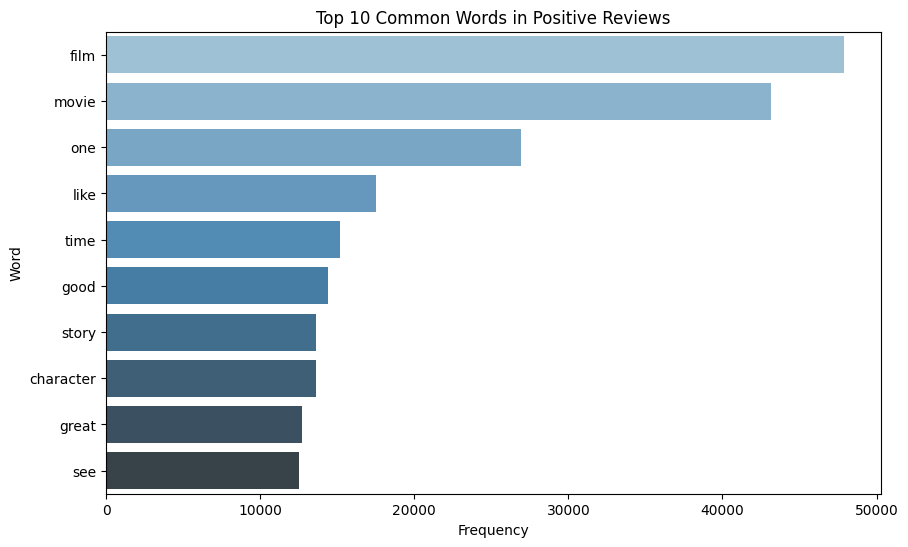

In [16]:
# Top 10 Common Words in Positive Reviews
positive_words = ' '.join(df[df['sentiment'] == 'positive']['cleaned_review']).split()
positive_word_freq = Counter(positive_words)
common_positive = pd.DataFrame(positive_word_freq.most_common(10), columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=common_positive, palette='Blues_d')
plt.title('Top 10 Common Words in Positive Reviews')
plt.savefig('top_positive_words.png')
plt.show()

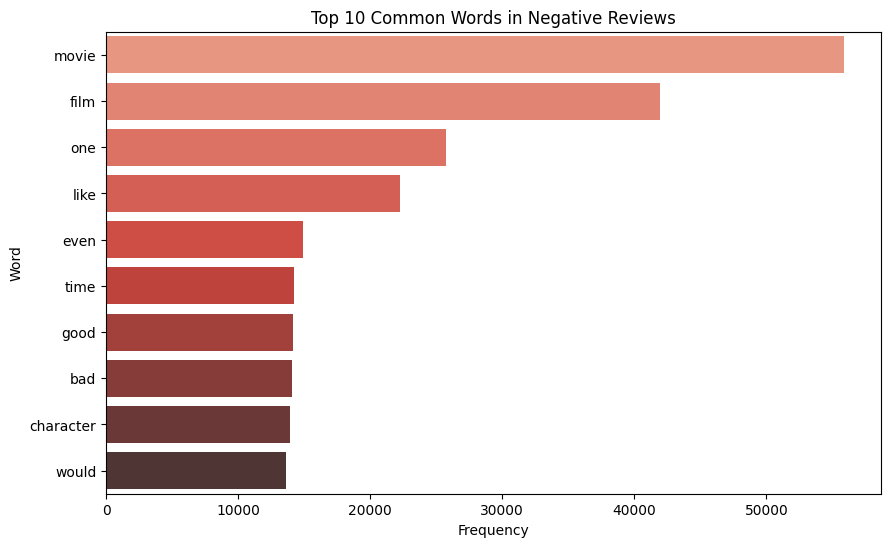

In [17]:
# Top 10 Common Words in Negative Reviews
negative_words = ' '.join(df[df['sentiment'] == 'negative']['cleaned_review']).split()
negative_word_freq = Counter(negative_words)
common_negative = pd.DataFrame(negative_word_freq.most_common(10), columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=common_negative, palette='Reds_d')
plt.title('Top 10 Common Words in Negative Reviews')
plt.savefig('top_negative_words.png')
plt.show()

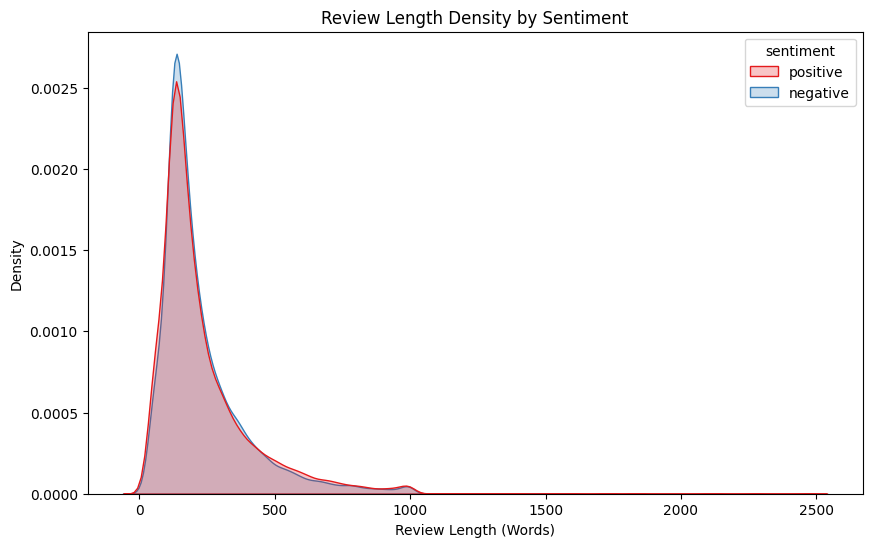

In [18]:
#  Review Length KDE by Sentiment
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='review_length', hue='sentiment', fill=True, palette='Set1')
plt.title('Review Length Density by Sentiment')
plt.xlabel('Review Length (Words)')
plt.ylabel('Density')
plt.savefig('review_length_kde.png')
plt.show()

In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment_label'], test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (40000,)
Testing Data Shape: (10000,)


In [20]:
# DistilBERT Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Encode reviews for DistilBERT
def encode_reviews(reviews, max_length=128):
    encodings = tokenizer(reviews.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings

train_encodings = encode_reviews(X_train)
test_encodings = encode_reviews(X_test)

In [32]:
# Create PyTorch dataset
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDBDataset(train_encodings, y_train)
test_dataset = IMDBDataset(test_encodings, y_test)

In [33]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [34]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    report_to='none',
    fp16=True if torch.cuda.is_available() else False
)

In [37]:
from transformers import TrainerCallback

# Custom callback to track accuracy
class AccuracyCallback(TrainerCallback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Validation accuracy from metrics
        eval_logits = trainer.predict(test_dataset).predictions
        eval_preds = np.argmax(eval_logits, axis=1)
        eval_acc = accuracy_score(y_test, eval_preds)
        self.eval_accuracies.append(eval_acc)
        # Log validation accuracy
        print(f"Epoch {state.epoch}: Validation Accuracy = {eval_acc:.4f}")

    def on_epoch_end(self, args, state, control, **kwargs):
        # Training accuracy (approximate, using a small batch)
        train_logits = trainer.predict(train_dataset).predictions
        train_preds = np.argmax(train_logits, axis=1)
        train_acc = accuracy_score(y_train, train_preds)
        self.train_accuracies.append(train_acc)
        print(f"Epoch {state.epoch}: Training Accuracy = {train_acc:.4f}")

# Initialize callback
accuracy_callback = AccuracyCallback()

In [38]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[accuracy_callback]
)

In [39]:
# Train and evaluate
trainer.train()
eval_results = trainer.evaluate()
print("\nDistilBERT Evaluation Results:", eval_results)

Epoch,Training Loss,Validation Loss
1,0.107600,0.555580
2,0.103700,0.658504
3,0.020500,0.743236
4,0.017700,0.776630
5,0.010600,0.865769


Epoch 1.0: Training Accuracy = 0.9864
Epoch 1.0: Validation Accuracy = 0.8832
Epoch 2.0: Training Accuracy = 0.9859
Epoch 2.0: Validation Accuracy = 0.8771
Epoch 3.0: Training Accuracy = 0.9987
Epoch 3.0: Validation Accuracy = 0.8899
Epoch 4.0: Training Accuracy = 0.9995
Epoch 4.0: Validation Accuracy = 0.8881
Epoch 5.0: Training Accuracy = 0.9997
Epoch 5.0: Validation Accuracy = 0.8886


Epoch 5.0: Validation Accuracy = 0.8886

DistilBERT Evaluation Results: {'eval_loss': 0.865768551826477, 'eval_runtime': 8.8431, 'eval_samples_per_second': 1130.829, 'eval_steps_per_second': 70.677, 'epoch': 5.0}


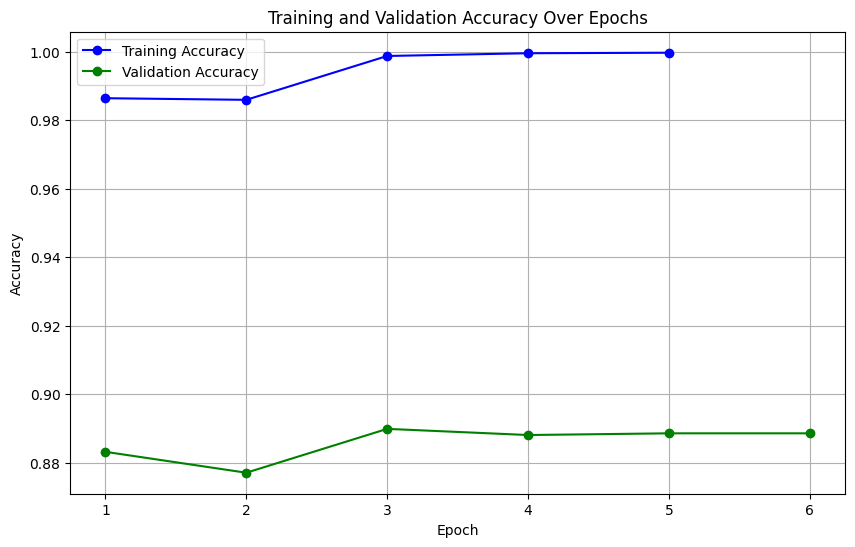

In [42]:
#  Accuracy Over Epochs
epochs = range(1, len(accuracy_callback.eval_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_callback.train_accuracies + [None], label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, accuracy_callback.eval_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_over_epochs.png')
plt.show()

In [43]:
# Predictions for evaluation
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

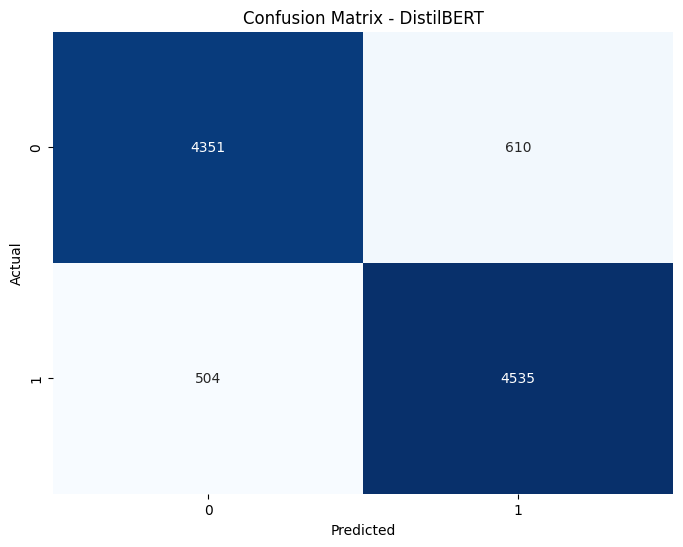

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()


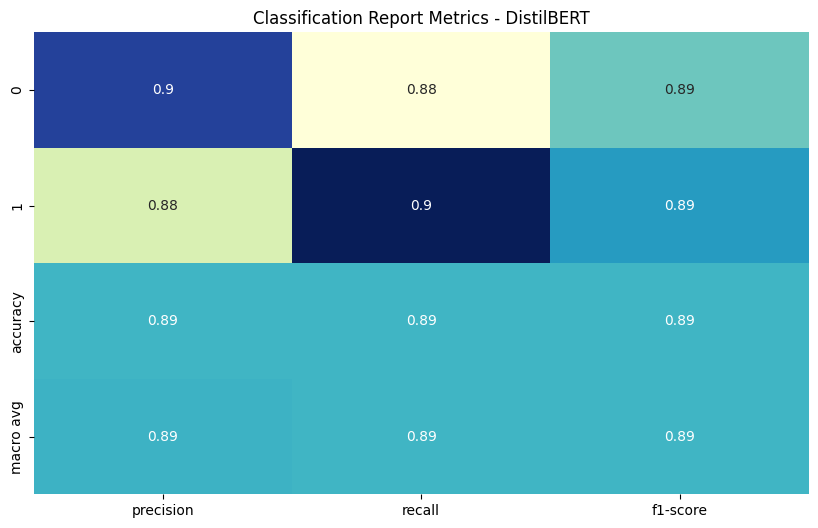

In [45]:
# Classification Report Metrics
report = classification_report(y_test, pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :3], annot=True, cmap='YlGnBu', cbar=False)
plt.title('Classification Report Metrics - DistilBERT')
plt.savefig('classification_report.png')
plt.show()

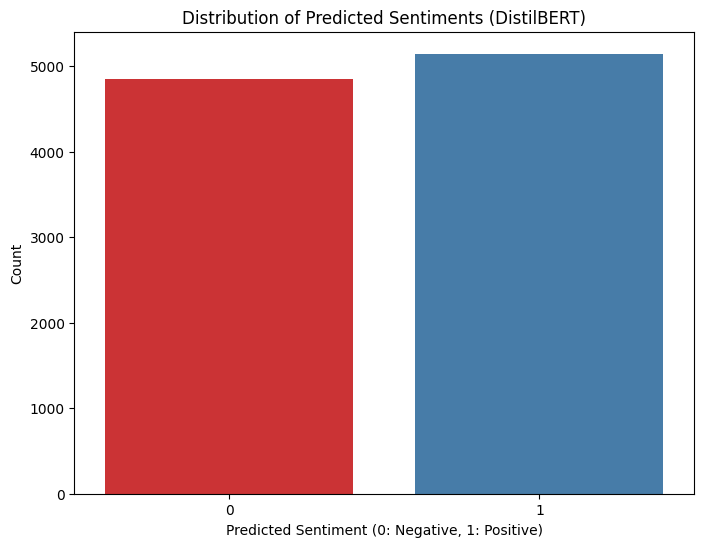

In [46]:
# Prediction Distribution
pred_df = pd.DataFrame({'Prediction': pred_labels})
plt.figure(figsize=(8, 6))
sns.countplot(x='Prediction', data=pred_df, palette='Set1')
plt.title('Distribution of Predicted Sentiments (DistilBERT)')
plt.xlabel('Predicted Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.savefig('prediction_distribution.png')
plt.show()


In [47]:
# Save the model and tokenizer
model.save_pretrained('./distilbert_imdb_model')
tokenizer.save_pretrained('./distilbert_imdb_model')
print("\nModel and tokenizer saved to './distilbert_imdb_model'")


Model and tokenizer saved to './distilbert_imdb_model'


In [48]:
# Function for user input prediction
def predict_sentiment(review, model, tokenizer):
    # Preprocess the input review
    cleaned_review = preprocess_text(review)
    # Encode the review
    encodings = tokenizer([cleaned_review], truncation=True, padding=True, max_length=128, return_tensors='pt')
    # Move to GPU
    encodings = {key: val.to(device) for key, val in encodings.items()}
    # Predict
    with torch.no_grad():
        outputs = model(**encodings)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return 'Positive' if prediction == 1 else 'Negative'

In [49]:
# User input loop
while True:
    user_review = input("\nEnter a movie review (or type 'exit' to quit): ")
    if user_review.lower() == 'exit':
        break
    if not user_review.strip():
        print("Please enter a valid review.")
        continue
    sentiment = predict_sentiment(user_review, model, tokenizer)
    print(f"Predicted Sentiment: {sentiment}")


Enter a movie review (or type 'exit' to quit): This movie was absolutely fantastic! The acting was top-notch, the plot kept me engaged from start to finish, and the visuals were stunning. Highly recommend it to everyone!
Predicted Sentiment: Positive

Enter a movie review (or type 'exit' to quit): The film was a complete disappointment. The storyline was predictable and boring, the characters lacked depth, and the pacing was way too slow. I wouldn’t watch it again.
Predicted Sentiment: Negative

Enter a movie review (or type 'exit' to quit): exit
